# Deep Learning
## Summative assessment
### Coursework 3

#### Instructions

This coursework is released on **Wednesday 20th March 9.00** and is due by **Wednesday 24th April 23.59**. It is worth **50%** of your overall mark. There are 4 questions in this assessment, and a total of 100 marks are available. **You should attempt to answer all questions.** In addition to the total number of marks per question below, an additional 5 marks is available for presentation and clarity/quality of code.

This assessment assesses your ability to design, implement, train and evaluate a generative deep learning model for a spoken audio dataset.

You can make imports as and when you need them throughout the notebook, and add code cells where necessary. Make sure your notebook executes correctly in sequence before submitting.

#### Submission instructions

The submission for this assessment will consist of a notebook (.ipynb file), PDF report and model submission.

Ensure your notebook executes correctly in order. Save your notebook .ipynb file **after you have executed it** (so that outputs are all showing). It is recommended to also submit a PDF/HTML copy of your executed notebook, in case the .ipynb file is corrupted for some reason.

Upload a zip file containing your notebook, separate PDF/HTML file(s), model(s) and any other relevant files to Coursera by the deadline above.

This assignment must be attempted individually; your submission must be your own, unaided work. Candidates are prohibited from discussing assessed coursework, and must abide by [Imperial College’s rules](https://www.imperial.ac.uk/media/imperial-college/administration-and-support-services/registry/academic-governance/public/academic-policy/academic-integrity/Examination-and-assessments---academic-integrity.pdf) regarding academic integrity and plagiarism. Unless specifically authorised within the assignment instructions, the submission of output from [generative AI tools](https://www.imperial.ac.uk/about/leadership-and-strategy/provost/vice-provost-education/generative-ai-tools-guidance/) (e.g., ChatGPT) for assessed coursework is prohibited. Violations will be treated as an examination offence. Enabling other candidates to plagiarise your work constitutes an examination offence. To ensure quality assurance is maintained, departments may choose to invite a random selection of students to an ‘authenticity interview’ on their submitted assessments.

In [1]:
! pip install pydub==0.25.1 -q


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import os
from IPython.display import Audio, display

import tensorflow as tf
import tensorflow_datasets as tfds
# from tensorflow.keras.layers import Layer

In [3]:
from tqdm import tqdm

In [44]:
SAMPLE_RATE = 8_000
FIXED_LENGTH = 3280 # pad or trim each audio to this length, value set to be the mean of all audio durations

#### The Free Spoken Digit Dataset (FSDD)

This assessment makes use of the [Free Spoken Digit Dataset](https://github.com/Jakobovski/free-spoken-digit-dataset). This dataset consists of recordings of spoken digits by a number of different speakers, all recorded at a sample rate of 8kHz. The recordings are trimmed so that they have near minimal silence at the beginnings and ends.

For this assessment, we will use the version of the dataset made available through TensorFlow Datasets ([https://www.tensorflow.org/datasets/catalog/spoken_digit](https://www.tensorflow.org/datasets/catalog/spoken_digit)).

The dataset consists 2,500 recordings from 5 different speakers. Using the TensorFlow Datasets API, this dataset can be downloaded and stored directly in a Dataset object using the code below.

In [5]:
ds = tfds.load(
    "spoken_digit",
    split="train",
    data_dir=os.path.join("data", "spoken_digit"),
    shuffle_files=False,
)

2024-04-26 09:24:03.493051: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-04-26 09:24:03.493074: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-04-26 09:24:03.493078: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-04-26 09:24:03.493138: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-26 09:24:03.493368: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
ds.element_spec

{'audio': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'audio/filename': TensorSpec(shape=(), dtype=tf.string, name=None),
 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}

#### VQ-VAE

The VQ-VAE was first developed in the following paper:

* van den Oord, A., Vinyals, O. & Kavukcuoglu, K. (2017), "Neural discrete representation learning", _Proceedings of the 31st International Conference on Neural Information Processing Systems_, 6309-6318.

In this assessment you will develop and train a vector-quantised variational autoencoder (VQ-VAE) model. This is a variant of the VAE algorithm that makes use of a discrete latent space. In particular, the VQ-VAE defines a _codebook_ $\mathbf{e} \in \mathbb{R}^{K \times D}$ for the latent embedding space, consisting of $K$ latent embedding vectors $e_i$ ($i=1,\ldots,K$), each of dimension $D$. The algorithm involves training encoder and decoder networks as usual. However, for a given input $x$, the encoder output $E(x) \in \mathbb{R}^D$ is quantised to the nearest latent embedding vector:

$$VQ(E(x)) = e_k,\quad\textrm{where }k = \underset{j}{\arg\min}||E(x) - e_j||_2,$$

where the $||\cdot||_2$ norm above is the Euclidean norm in $\mathbb{R}^D$. This quantized latent vector is then passed through the decoder to output the likelihood $p_\theta(x \mid z)$ as usual.

The quantisation stage of the VQ-VAE means that it is not possible to compute gradients with respect to the encoder variables. The solution to this problem in the VQ-VAE is to use the _straight through estimator_, in which the gradients computed with respect to the quantised embeddings are simply passed unaltered to the encoder. This process means that the codebook embeddings $e_i$ do not receive any gradient updates (for details, refer to the implementation referenced in question 3, which makes this process explicit). The VQ-VAE objective therefore adds two additional terms to learn the codebook embeddings:

$$
L = \mathbb{E}_{q_\phi(z \mid x)}[\log p_\theta(x \mid z) ] + ||\textrm{sg}[E(x)] - VQ(E(x))||^2_2 + \beta || E(x) - \textrm{sg}[VQ(E(x))]||_2^2
$$

In the above, $\textrm{sg}$ is the _stop gradient_ operator that is defined as identity in the forward pass but has zero partial derivates (see [`tf.stop_gradient`](https://www.tensorflow.org/api_docs/python/tf/stop_gradient)). This means that when evaluating the loss function above, the stop gradient operator can be ignored, but when computing derivatives of the loss with respect to the model parameters, the partial derivatives of $\textrm{sg}[E(x)]$ and $\textrm{sg}[VQ(E(x))]$ with respect to the model parameters will be zero. The constant $\beta$ is usually taken set to $\beta=0.25$ by default, as in the original paper.

The first term in the objective $L$ above is the reconstruction loss, the second term is the _codebook loss_, and the third term is the _commitment loss_. The Kullback-Leibler divergence term in the ELBO is constant and so is ignored for training.

In this assessment, you will design, implement, train and evaluate a VQ-VAE for the spoken digit dataset, and use it to learn a generative model of the spoken audio.

### Question 1 (Total 15 marks)

The loaded Dataset returns a dictionary with keys `"audio"`, `"audio/filename"` and `"label"`. For this assessment you will only need the `"audio"` entry, and the other entries can be discarded.

In this question, you should carry out a basic exploration and analysis of the dataset; computing, displaying and visualising any properties you deem to be relevant. You can also use comments and/or markdown as appropriate.

All of the Dataset preparation/preprocessing for question 2a) should be done in this question, so that it is ready for training the VQ-VAE.

_Hint: an audio file can be played within a jupyter notebook using the `Audio` class from the `IPython.display` module (imported above). See [here](https://ipython.org/ipython-doc/3/api/generated/IPython.display.html) for usage._

**(15 marks)**

In [7]:
def analyze_dataset(ds):
    """Plots:
    1. Histogram of the audio durations in seconds.
    2. Histogram of the amplitude distribution.
    3. Distriubtion of the digits.

    Gives information about:
    1. Total samples in the dataset.
    2. Average audio duration in seconds.
    3. Minimum audio duration in seconds.
    4. Maximum audio duration in seconds.
    """
    durations = []
    labels = []
    amplitudes = []
    for example in ds:
        audio = example["audio"]
        label = example["label"]
        durations.append(len(audio) / SAMPLE_RATE)
        labels.append(label.numpy())
        amplitudes.append(tf.reduce_max(audio).numpy())

    print("Total samples:", len(durations))
    print("Average duration:", np.mean(durations), "seconds")
    print("Min duration:", np.min(durations), "seconds")
    print("Max duration:", np.max(durations), "seconds")

    plt.hist(durations, bins=30)
    plt.title("Histogram of Audio Durations")
    plt.xlabel("Duration (s)")
    plt.ylabel("Count")
    plt.show()

    plt.hist(amplitudes, bins=30, color="green")
    plt.title("Amplitude Distribution")
    plt.xlabel("Max Amplitude")
    plt.ylabel("Count")
    plt.show()

    plt.hist(labels, bins=np.arange(11) - 0.5, edgecolor="black")
    plt.xticks(np.arange(10))
    plt.title("Distribution of Digits")
    plt.xlabel("Digit Label")
    plt.ylabel("Count")
    plt.show()

In [8]:
def plot_waveforms(ds, num_samples: int = 5, sampling_rate: int = SAMPLE_RATE):
    """Plots the waveforms of a number of samples `num_samples`,
    with time axis converted to seconds based on the sampling
    rate `SAMPLE_RATE`.
    """
    _, axes = plt.subplots(num_samples, 1, figsize=(10, 3 * num_samples))
    for i, example in enumerate(ds.take(num_samples)):
        audio = example["audio"].numpy()
        time_axis = np.arange(len(audio)) / sampling_rate  # time axis in seconds
        axes[i].plot(time_axis, audio)
        axes[i].set_title(f"Digit: {example['label'].numpy()}")
        axes[i].set_xlabel("Time (s)")
        axes[i].set_ylabel("Amplitude")
        axes[i].set_xlim([0, len(audio) / sampling_rate])

    plt.tight_layout()
    plt.show()

In [9]:
def play_audio_samples(ds, num_samples: int = 5, sampling_rate: int = SAMPLE_RATE):
    """Plays the audio for a number of samples `num_samples` considering the
    sampling rate `SAMPLE_RATE`.
    """
    for example in ds.take(num_samples):
        display(Audio(data=example["audio"].numpy(), rate=sampling_rate))

In [10]:
def pad_or_trim(feature, length: int = FIXED_LENGTH):
    """Pads or trims the recordings to the same `length`.
    Defaults to `FIXED_LENGTH`.
    """
    audio = feature["audio"]
    audio_length = tf.shape(audio)[0]

    def trim_audio(length: int = FIXED_LENGTH):
        return audio[:length]

    def pad_audio(length: int = FIXED_LENGTH):
        return tf.pad(audio, [[0, length - audio_length]], "CONSTANT")

    feature["audio"] = tf.cond(audio_length > length, trim_audio, pad_audio)

    return feature

In [11]:
def normalize_audio(feature):
    """Normalizes the audio to get in the range (-1, 1).
    """
    max_val = tf.reduce_max(tf.abs(feature["audio"]))
    feature["audio"] = feature["audio"] / max_val
    feature["audio"] = tf.expand_dims(feature["audio"], -1)
    feature["audio"] = tf.cast(feature["audio"], tf.float32)
    
    return feature

Total samples: 2500
Average duration: 0.4100790000000001 seconds
Min duration: 0.1435 seconds
Max duration: 2.28275 seconds


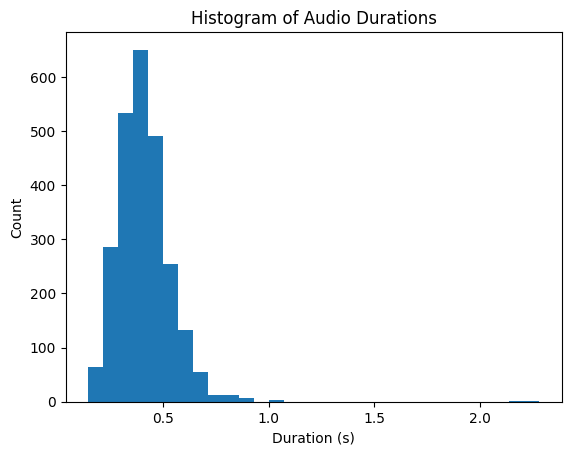

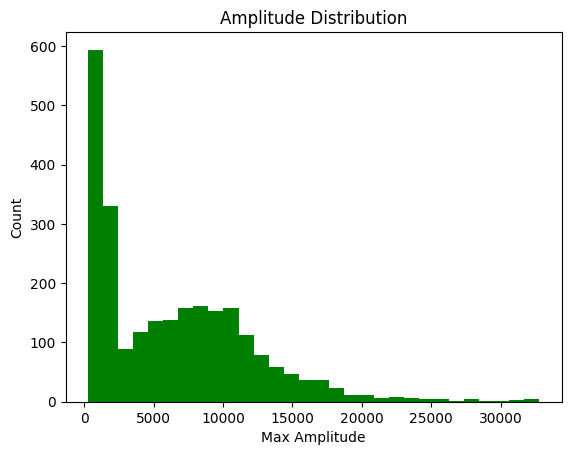

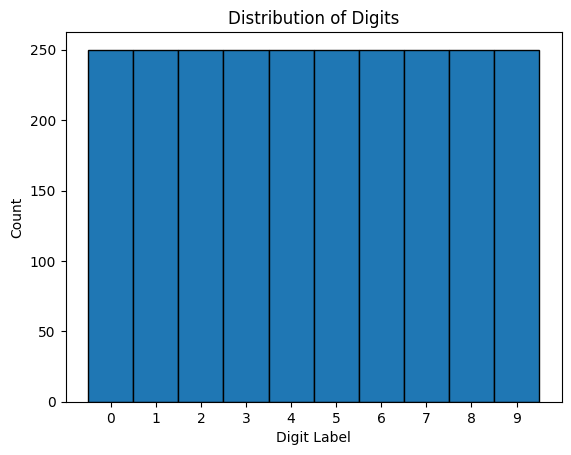

In [12]:
analyze_dataset(ds)

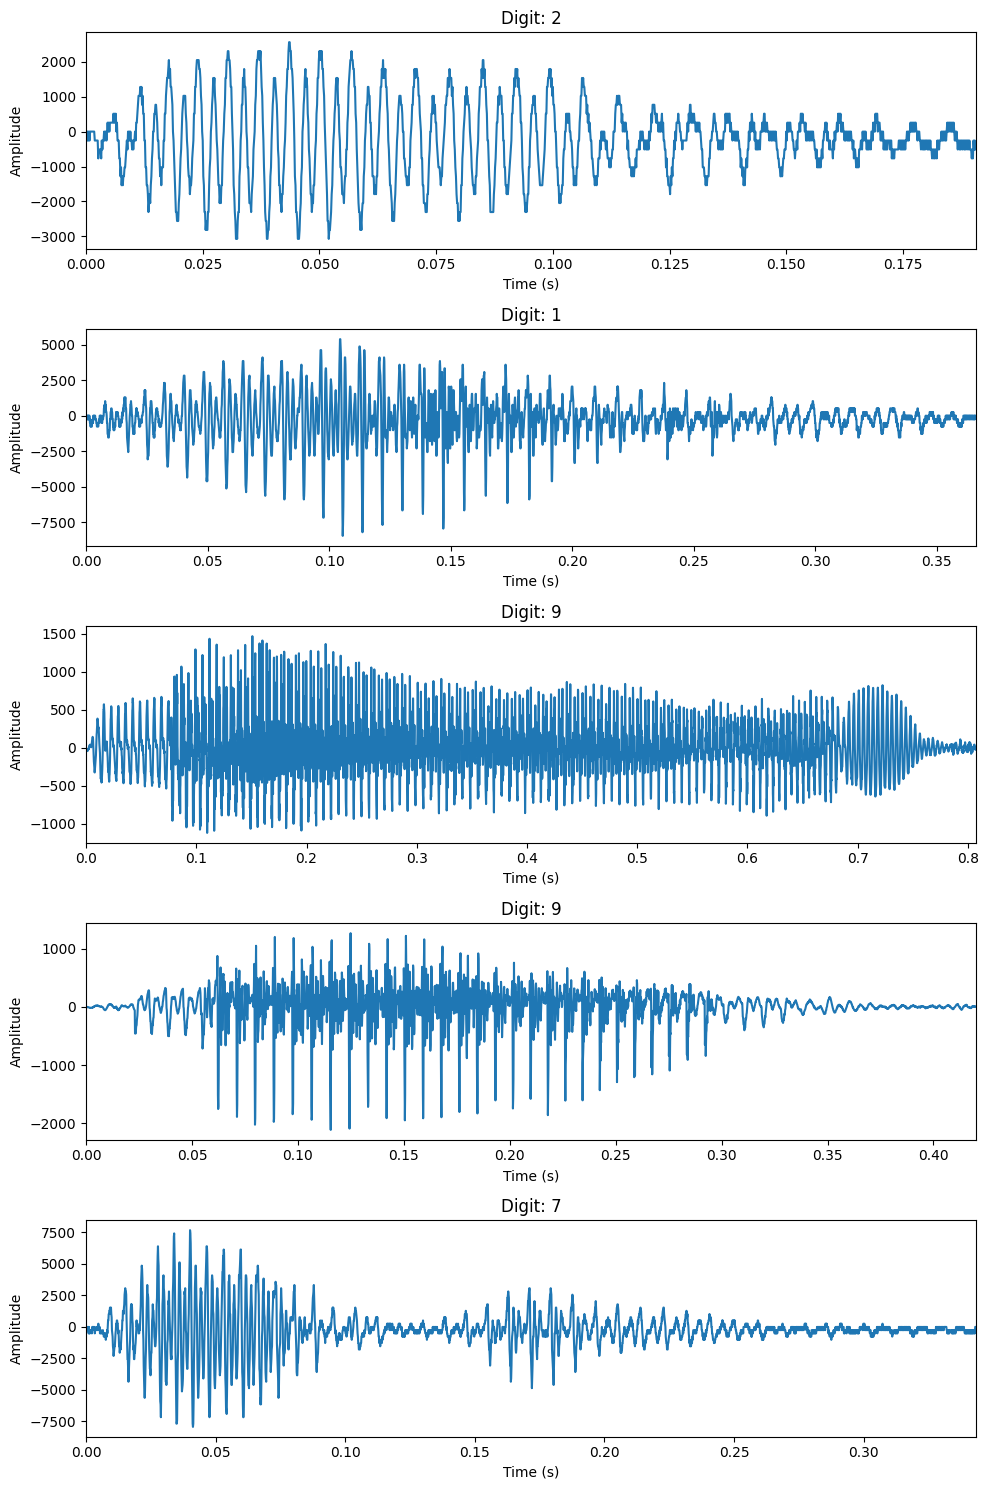

In [13]:
plot_waveforms(ds)

In [14]:
play_audio_samples(ds)

In [15]:
ds = ds.map(pad_or_trim)

In [16]:
ds = ds.map(normalize_audio)

In [17]:
# analyze_dataset(ds)

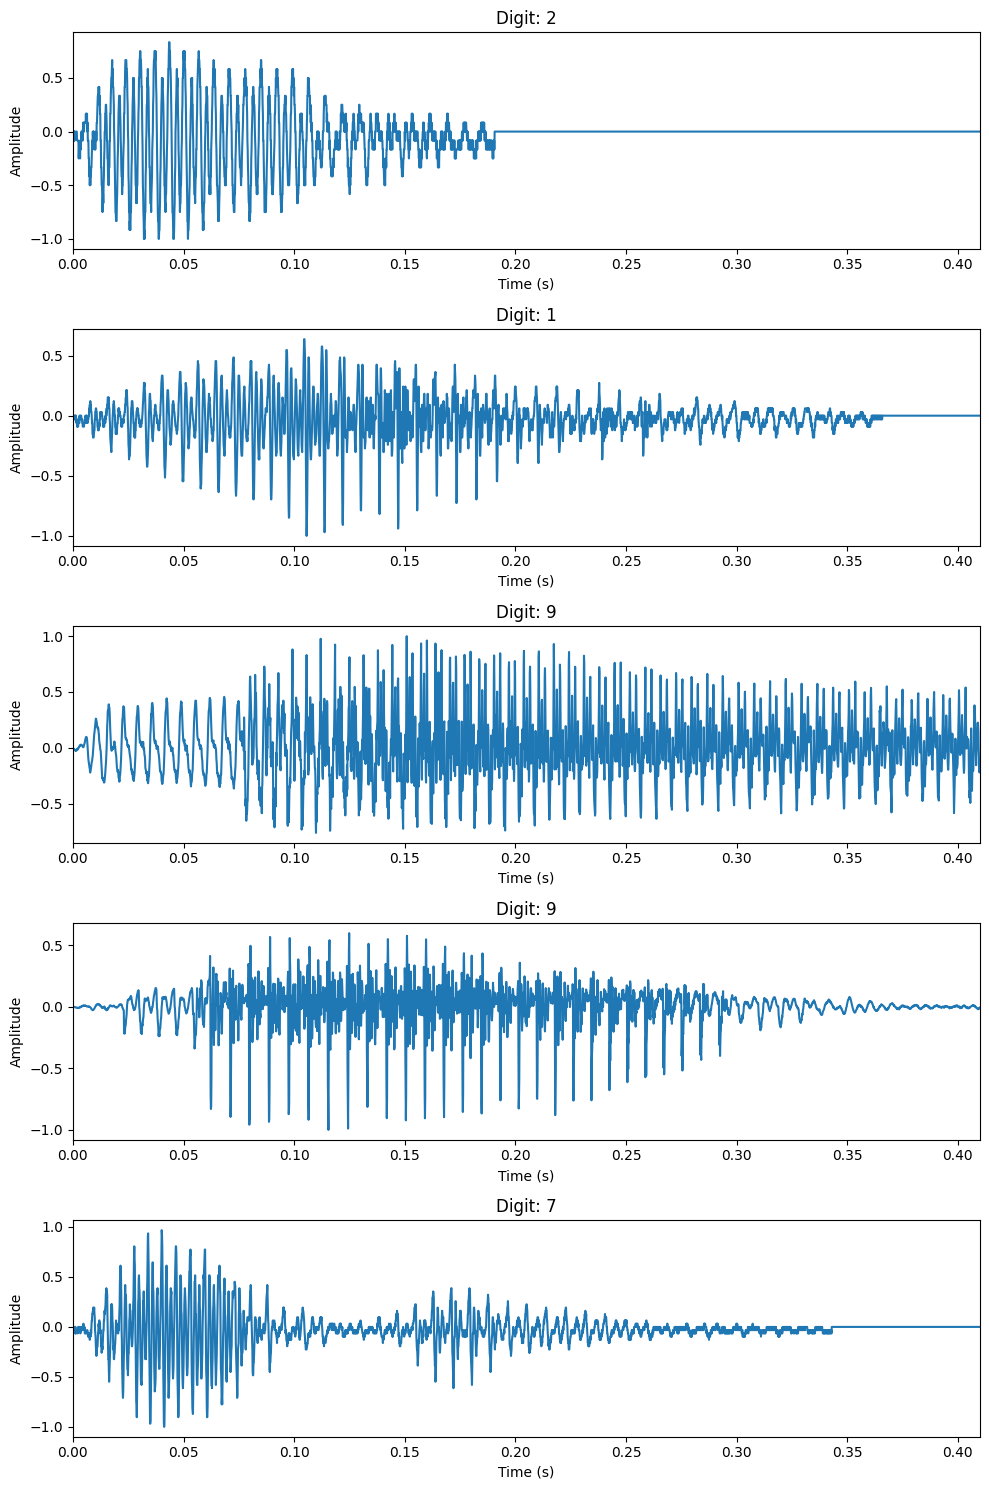

In [18]:
plot_waveforms(ds)

In [19]:
num_samples = len(ds)
train_size = int(0.7 * num_samples)  # 70% of the data for training
val_size = int(0.2 * num_samples)   # 20% for validation
test_size = num_samples - train_size - val_size  # Remaining 10% for testing
ds = ds.shuffle(buffer_size=num_samples, reshuffle_each_iteration=False)
train_ds = ds.take(train_size)
val_ds = ds.skip(train_size).take(val_size)
test_ds = ds.skip(train_size + val_size)


In [20]:
# Batch and prefetch for performance
train_ds = train_ds.shuffle(train_size).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

### Question 2 (Total 25 marks)

a) In the VQ-VAE, the variational posterior output by the encoder is deterministic:

$$q_\phi(z = e_k \mid x) = \left\{
\begin{array}{l}
~1 \quad\textrm{for}\quad k=\underset{j}{\arg\min} ||E(x) - e_j||\\
~0 \quad\textrm{otherwise}
\end{array}
\right.
$$

where in the above, $\phi$ represents the parameters of the encoder. Show that by choosing a simple uniform distribution over the codebook vectors $e_i$ as the prior distribution $p(z)$, the KL-divergence term of the ELBO objective is equal to a constant.

**(5 marks)**

We need to calculate the KL-divergence between the variational posterior and the prior. The variational posterior is deterministic and defined as:

$$
q_{\phi} (z = e_k \mid x) = \begin{cases}
1 & \textrm{for}\quad k=\underset{j}{\arg\min} ||E(x) - e_j|| \\
0 & \textrm{otherwise},
\end{cases}
$$
meaning that for each input $x$, there exists exactly one $k$ such that $q_\phi(z = e_k | x) = 1$, and for all other $j \neq k$, $q_\phi(z = e_j | x) = 0$. Let the prior distribution $p(z)$ be a uniform distribution over the codebook vectors $e_k$, such that
$$
p(z = e_k) = \frac{1}{K} \quad \forall k \in {1, 2, \ldots, K},
$$
where $K$ is the total number of codebook vectors.The KL-divergence between the variational posterior $q_{\phi} (z \mid x)$ and the prior $p(z)$ is given by

$$
D_{KL}(q_\phi(z|x) || p(z)) = \sum_{k=1}^K q_\phi(z = e_k|x) \log \frac{q_\phi(z = e_k|x)}{p(z = e_k)}.
$$
We can substitute $p(z = e_k)$:
$$
D_{KL}(q_\phi(z|x) || p(z)) = \sum_{k=1}^K q_\phi(z = e_k|x) \log \frac{q_\phi(z = e_k|x)}{\frac{1}{K}}
$$
Also, $q_\phi(z = e_k|x) = 1$ only for the $k$ corresponding to the minimum distance, therefore we can simplify to:

$$
D_{KL}(q_\phi(z|x) || p(z)) = \log K.
$$
Therefore, the KL-divergence term of the ELBO objective is equal to $\log K$, which is a constant that depends only on the size of the codebook and not on the input $x$ or the encoder parameters $\phi$. Meaning that in the ELBO for VQ-VAE, the KL term contributes a constant additive term to the loss, and hence does not influence the optimization of encoder parameters $\phi$ in terms of adaptive changes during training. Thus, choosing a uniform prior over the codebook vectors simplifies the VQ-VAE training by making the KL-divergence term a non-informative, constant value.

b) The VQ-VAE as described above has an implementation that is available on the Keras website [here](https://keras.io/examples/generative/vq_vae/). In particular, the implementation of the vector quantisation and addition of the codebook and commitment loss is done with the `VectorQuantizer` layer.

You should write your own custom Layer class that is based on the `VectorQuantizer` layer, but with the following amendments:

1) The codebook loss should be removed, and instead the layer should use exponential moving average updates for the codebook during training, as follows:
$$
N_i^{(t)} := N_i^{(t-1)} * \gamma + n_i^{(t)}(1 - \gamma),\quad m_i^{(t)} := m_i^{(t-1)} * \gamma + \sum_j^{n_i^{(t)}} E(x)_{i,j}^{(t)}(1-\gamma),\quad e_i^{(t)} :=\frac{m_i^{(t)}}{N_i^{(t)}},\qquad i=1,\ldots,K
$$
where $n_i^{(t)}$ is the number of vectors in $E(x)$ in the minibatch that are quantized to codebook vector $e_i$ (cluster size), and $0 < \gamma < 1$ is a decay parameter, normally set to $\gamma=0.99$ as default. The moving averages are typically initialised as $m_i^{(0)} = e_i^{(0)}$ and $N_i^{(0)} = 0$. Note that the above update is independent of the gradient-based optimizer used to update the parameters of the encoder and decoder networks.

2) In place of the (single) codebook vector quantisation, your custom Layer class should use _residual vector quantisation_ (RVQ). This is a multi-stage vector quantiser, which involves $N_q$ layers of vector quantisation as follows. Define a sequence of codebooks $\mathbf{e}^{(j)}\in\mathbb{R}^{K\times D}$, $j=1,\ldots,N_q$. Codebook $\mathbf{e}^{(j)}$ consists of $K$ latent embedding vectors $e_i^{(j)}$, each of dimension $D$ as before.

The encoder output $E(x)$ is first quantised using the first codebook:

$$VQ^{(1)}(E(x)) = e_k^{(1)},\quad\textrm{where }k = \underset{j}{\arg\min}||E(x) - e_j^{(1)}||_2,$$
    
The residual $\hat{e}^{(1)} := E(x) - VQ^{(1)}(E(x))$ is then quantised using the second codebook to give $VQ^{(2)}(\hat{e}^{(1)})$, and so on. The RVQ layer then sends the sum of the quantised vectors on to the decoder. The algorithm is summarised in the following pseudocode.

<img src="figures/rvq_pseudocode.png" alt="RVQ pseudocode" style="width: 450px;"/>

**(15 marks)**

In [21]:
class RVQVectorQuantizer(tf.keras.layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, num_stages, gamma=0.99, **kwargs):
        super(RVQVectorQuantizer, self).__init__(**kwargs)
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.num_stages = num_stages
        self.gamma = gamma

        self.embeddings = [
            self.add_weight(
                name=f"embedding_{i}",
                shape=(num_embeddings, embedding_dim),
                initializer="uniform",
                trainable=False,
            )
            for i in range(num_stages)
        ]
        self.moving_averages = [
            self.add_weight(
                name=f"moving_avg_{i}",
                shape=(num_embeddings, embedding_dim),
                initializer="zeros",
                trainable=False,
            )
            for i in range(num_stages)
        ]
        self.cluster_size = [
            self.add_weight(
                name=f"cluster_size_{i}",
                shape=(num_embeddings,),
                initializer="zeros",
                trainable=False,
            )
            for i in range(num_stages)
        ]

    def call(self, inputs, training=None):
        quantized = tf.zeros_like(inputs)
        residual = inputs
        for stage in range(self.num_stages):
            distances = tf.norm(
                tf.expand_dims(residual, axis=2) - self.embeddings[stage], axis=-1
            )
            nearest_indices = tf.argmin(distances, axis=-1)
            nearest_embeddings = tf.gather(self.embeddings[stage], nearest_indices)

            if training:
                updated_cluster_size = tf.math.unsorted_segment_sum(
                    data=tf.ones_like(nearest_indices, dtype=tf.float32),
                    segment_ids=nearest_indices,
                    num_segments=self.num_embeddings,
                )
                self.cluster_size[stage].assign(
                    self.gamma * self.cluster_size[stage]
                    + (1 - self.gamma) * updated_cluster_size
                )

                flat_residual = tf.reshape(residual, (-1, self.embedding_dim))
                flat_indices = tf.reshape(nearest_indices, (-1,))
                summed_embeddings = tf.math.unsorted_segment_sum(
                    data=flat_residual,
                    segment_ids=flat_indices,
                    num_segments=self.num_embeddings,
                )
                self.moving_averages[stage].assign(
                    self.gamma * self.moving_averages[stage]
                    + (1 - self.gamma) * summed_embeddings
                )

                new_embeddings = self.moving_averages[stage] / tf.expand_dims(
                    tf.maximum(self.cluster_size[stage], 1e-8), axis=-1
                )
                self.embeddings[stage].assign(new_embeddings)

            quantized += nearest_embeddings
            residual -= nearest_embeddings

        return quantized

    def get_config(self):
        config = super(RVQVectorQuantizer, self).get_config()
        config.update(
            {
                "num_embeddings": self.num_embeddings,
                "embedding_dim": self.embedding_dim,
                "num_stages": self.num_stages,
                "gamma": self.gamma,
            }
        )
        return config

c) Test your custom vector quantisation layer above by training a simple model on MNIST and displaying a few reconstructions of the model.

**(5 marks)**

In [22]:
def get_encoder(latent_dim, num_embeddings, embedding_dim, num_stages):
    actual_latent_dim = num_stages * embedding_dim
    inputs = tf.keras.Input(shape=(28, 28, 1))
    x = tf.keras.layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(inputs)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = tf.keras.layers.Flatten()(x)
    encoder_outputs = tf.keras.layers.Dense(actual_latent_dim, activation='relu')(x)
    encoder_outputs = tf.keras.layers.Reshape((num_stages, embedding_dim))(encoder_outputs)
    
    return tf.keras.models.Model(inputs, encoder_outputs, name="encoder")

def get_decoder(embedding_dim, num_stages):
    latent_dim = num_stages * embedding_dim
    latent_inputs = tf.keras.layers.Input(shape=(num_stages, embedding_dim))
    x = tf.keras.layers.Flatten()(latent_inputs)
    x = tf.keras.layers.Dense(7*7*64, activation='relu')(x)
    x = tf.keras.layers.Reshape((7, 7, 64))(x)
    x = tf.keras.layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = tf.keras.layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    decoder_outputs = tf.keras.layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
    
    return tf.keras.models.Model(latent_inputs, decoder_outputs, name="decoder")

In [23]:
class VQVAE(tf.keras.models.Model):
    def __init__(self, latent_dim, num_embeddings, embedding_dim, num_stages):
        super(VQVAE, self).__init__()
        self.encoder = get_encoder(
            latent_dim, num_embeddings, embedding_dim, num_stages
        )
        self.decoder = get_decoder(embedding_dim, num_stages)
        self.vector_quantizer = RVQVectorQuantizer(
            num_embeddings, embedding_dim, num_stages
        )

    def call(self, inputs):
        z = self.encoder(inputs)
        z_q = self.vector_quantizer(z)
        reconstructed = self.decoder(z_q)

        return reconstructed

In [24]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

In [25]:
vqvae = VQVAE(latent_dim=64, num_embeddings=128, embedding_dim=64, num_stages=8)
vqvae.compile(optimizer="adam", loss="mse")
vqvae.fit(x_train, x_train, epochs=10, validation_split=0.1)

Epoch 1/10


2024-04-26 09:24:06.241256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1688/1688 [==============================] - 30s 17ms/step - loss: 0.0207 - val_loss: 0.0126
Epoch 2/10
1688/1688 [==============================] - 26s 15ms/step - loss: 0.0113 - val_loss: 0.0103
Epoch 3/10
1688/1688 [==============================] - 26s 15ms/step - loss: 0.0097 - val_loss: 0.0092
Epoch 4/10
1688/1688 [==============================] - 26s 15ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 5/10
1688/1688 [==============================] - 25s 15ms/step - loss: 0.0083 - val_loss: 0.0082
Epoch 6/10
1688/1688 [==============================] - 26s 16ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 7/10
1688/1688 [==============================] - 26s 15ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 8/10
1688/1688 [==============================] - 26s 15ms/step - loss: 0.0075 - val_loss: 0.0075
Epoch 9/10
1688/1688 [==============================] - 26s 15ms/step - loss: 0.0073 - val_loss: 0.0074
Epoch 10/10
1688/1688 [==============================] - 26s 15ms/step - lo

In [26]:
def display_reconstructions(model, images, n_images=10):
    idx = np.random.choice(len(images), n_images)
    originals = images[idx]
    reconstructions = model.predict(originals)

    plt.figure(figsize=(20, 4))
    for i in range(n_images):
        # Display original
        ax = plt.subplot(2, n_images, i + 1)
        plt.imshow(originals[i].reshape(28, 28))
        plt.title("Original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n_images, i + 1 + n_images)
        plt.imshow(reconstructions[i].reshape(28, 28))
        plt.title("Reconstructed")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

1/1 [==============================] - 0s 263ms/step


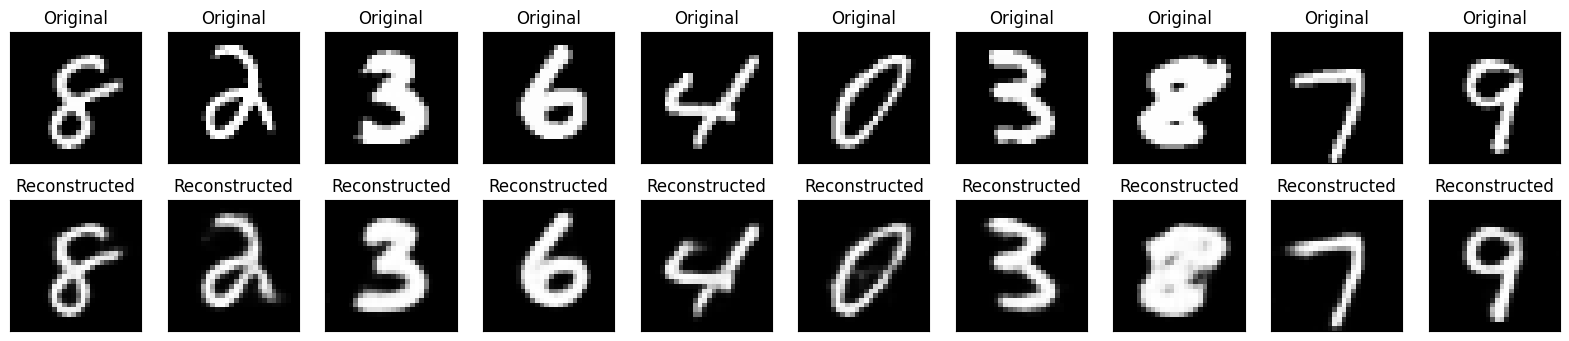

In [27]:
display_reconstructions(vqvae, x_test)

### Question 3 (Total 40 marks)

a) Design, implement and train a VQ-VAE for the spoken digit dataset. You are free to choose any architecture for the encoder and decoder networks, but your model should use the custom RVQ layer from question 2, with $N_q\ge2$ codebooks. (If you have been unable to implement this custom layer, then you should use the `VectorQuantizer` layer from the [Keras website](https://keras.io/examples/generative/vq_vae/)). You can also make additions or modifications to the training algorithm if you wish.

Your trained model should output a sequence of codebook vectors using the encoder and RVQ layer, which are then decoded by the decoder network to reconstruct the original input.

You should record any experiments you carry out along with the training logs, to be reported in question 4. Your code in this question does not need to be presented so that it runs all experiments, it can be set out to run the best experiment only.

Display some examples (playable using the `Audio` class from the `IPython.display` module as in question 1) from the dataset along with their reconstructions to demonstrate the trained model.

**(25 marks)**

In [28]:
class SimpleEncoder(tf.keras.layers.Layer):
    def __init__(self, embedding_dim):
        super(SimpleEncoder, self).__init__()
        self.conv1 = tf.keras.layers.Conv1D(8, 3, activation='relu', padding='same', strides=2)
        self.conv2 = tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same', strides=2)
        self.conv3 = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same', strides=2)
        self.final_conv = tf.keras.layers.Conv1D(embedding_dim, 3, activation=None, padding='same', strides=1)

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.final_conv(x)
        
        return x

class SimpleDecoder(tf.keras.layers.Layer):
    def __init__(self):
        super(SimpleDecoder, self).__init__()
        self.conv1T = tf.keras.layers.Conv1DTranspose(32, 3, activation='relu', padding='same', strides=1)
        self.conv2T = tf.keras.layers.Conv1DTranspose(16, 3, activation='relu', padding='same', strides=2)
        self.conv3T = tf.keras.layers.Conv1DTranspose(8, 3, activation='relu', padding='same', strides=2)
        self.final_convT = tf.keras.layers.Conv1DTranspose(1, 3, activation='tanh', padding='same', strides=2)

    def call(self, inputs):
        x = self.conv1T(inputs)
        x = self.conv2T(x)
        x = self.conv3T(x)
        x = self.final_convT(x)
        return x

In [29]:
class VQVAEModel(tf.keras.Model):
    def __init__(self, encoder, decoder, rvq_layer, loss_function=None):
        super(VQVAEModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.rvq_layer = rvq_layer
        self.loss_function = loss_function

    def call(self, inputs, training=False):
        z_e = self.encoder(inputs)
        z_q = self.rvq_layer(z_e, training=training)
        reconstructed = self.decoder(z_q)
        
        return reconstructed, z_e, z_q

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            outputs = self(x, training=True)  # outputs = (reconstructed, z_e, z_q)
            loss = self.loss_function(y, outputs)  # Use the custom loss function

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        return {'loss': loss}

    def test_step(self, data):
        x, y = data
        outputs = self(x, training=False)
        loss = self.loss_function(y, outputs)
        
        return {'loss': loss}

In [30]:
class VQVAELoss(tf.keras.losses.Loss):
    def __init__(self, commitment_cost=0.25, **kwargs):
        super(VQVAELoss, self).__init__(**kwargs)
        self.commitment_cost = commitment_cost

    def call(self, y_true, y_pred):
        reconstructed, z_e, z_q = y_pred
        reconstruction_loss = tf.reduce_mean(tf.square(y_true - reconstructed))
        commitment_loss = tf.reduce_mean(tf.square(z_e - tf.stop_gradient(z_q)))

        return reconstruction_loss + self.commitment_cost * commitment_loss 

In [31]:
num_stages = 32
embedding_dim = 16
num_embeddings = 16
gamma=0.8

encoder = SimpleEncoder(embedding_dim)
decoder = SimpleDecoder()
rvq_layer = RVQVectorQuantizer(num_embeddings, embedding_dim, num_stages, gamma)
loss_function = VQVAELoss(commitment_cost=0.25)
vqvae_model = VQVAEModel(encoder=encoder, decoder=decoder, rvq_layer=rvq_layer, loss_function=loss_function)
vqvae_model.compile(optimizer='adam')

In [32]:
average_loss_list = []
average_val_loss_list = []
for epoch in tqdm(range(15)):
    # Training loop
    total_loss = 0
    batch_count = 0
    for batch in train_ds:
        loss_value = vqvae_model.train_step((batch["audio"], batch["audio"]))
        total_loss += loss_value['loss'].numpy()
        batch_count += 1
    average_loss = total_loss / batch_count
    average_loss_list.append(average_loss)
    
    # Validation loop
    total_val_loss = 0
    val_batch_count = 0
    for batch in val_ds:
        # Forward pass only to compute the loss
        val_loss_value = vqvae_model.test_step((batch["audio"], batch["audio"]))
        total_val_loss += val_loss_value['loss'].numpy()
        val_batch_count += 1
    average_val_loss = total_val_loss / val_batch_count
    average_val_loss_list.append(average_val_loss)
    
    # Print out the average losses for this epoch
    print(f'Epoch {epoch + 1}, Average Training Loss: {average_loss}, Average Validation Loss: {average_val_loss}')


  7%|▋         | 1/15 [00:08<01:52,  8.02s/it]

Epoch 1, Average Training Loss: 0.035134168409488416, Average Validation Loss: 0.029330406803637743


 13%|█▎        | 2/15 [00:14<01:33,  7.17s/it]

Epoch 2, Average Training Loss: 0.020981762879951432, Average Validation Loss: 0.01584210724104196


 20%|██        | 3/15 [00:21<01:23,  6.99s/it]

Epoch 3, Average Training Loss: 0.012658001601018688, Average Validation Loss: 0.010507435887120664


 27%|██▋       | 4/15 [00:27<01:15,  6.84s/it]

Epoch 4, Average Training Loss: 0.009369204548949545, Average Validation Loss: 0.008793355751549825


 33%|███▎      | 5/15 [00:34<01:07,  6.75s/it]

Epoch 5, Average Training Loss: 0.008350481177595528, Average Validation Loss: 0.008118774916511029


 40%|████      | 6/15 [00:41<01:00,  6.74s/it]

Epoch 6, Average Training Loss: 0.007902158788320693, Average Validation Loss: 0.007753973652143031


 47%|████▋     | 7/15 [00:48<00:54,  6.76s/it]

Epoch 7, Average Training Loss: 0.00761070331050591, Average Validation Loss: 0.007546797540271655


 53%|█████▎    | 8/15 [00:55<00:47,  6.83s/it]

Epoch 8, Average Training Loss: 0.007430859087881716, Average Validation Loss: 0.007351975771598518


 60%|██████    | 9/15 [01:01<00:41,  6.86s/it]

Epoch 9, Average Training Loss: 0.007307419231669469, Average Validation Loss: 0.007259595382492989


 67%|██████▋   | 10/15 [01:08<00:34,  6.82s/it]

Epoch 10, Average Training Loss: 0.007250803260302001, Average Validation Loss: 0.007287716580322012


 73%|███████▎  | 11/15 [01:15<00:27,  6.91s/it]

Epoch 11, Average Training Loss: 0.00728251738473773, Average Validation Loss: 0.007336257986025885


 80%|████████  | 12/15 [01:22<00:20,  6.86s/it]

Epoch 12, Average Training Loss: 0.007322291979058222, Average Validation Loss: 0.007286408537765965


 87%|████████▋ | 13/15 [01:29<00:13,  6.82s/it]

Epoch 13, Average Training Loss: 0.007370782287960702, Average Validation Loss: 0.007349027786403894


 93%|█████████▎| 14/15 [01:36<00:06,  6.86s/it]

Epoch 14, Average Training Loss: 0.007401435627517375, Average Validation Loss: 0.007401006208965555


100%|██████████| 15/15 [01:44<00:00,  6.99s/it]

Epoch 15, Average Training Loss: 0.007472976508804343, Average Validation Loss: 0.0075030171719845384


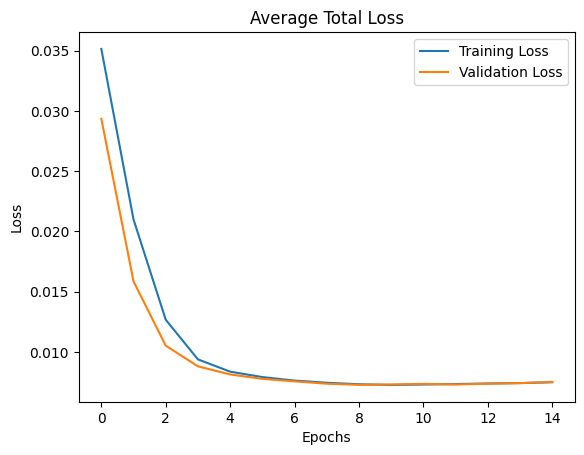

In [33]:
plt.plot(average_loss_list, label='Training Loss')
plt.plot(average_val_loss_list, label='Validation Loss')
plt.title("Average Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [34]:
for record in test_ds.take(1):
    test_audio = record["audio"]
    print(test_audio.shape)
    print(record["label"])
    reconstructed_audio = vqvae_model.predict(test_audio)

(32, 3280, 1)
tf.Tensor([2 7 2 3 0 1 4 7 4 4 6 8 1 3 4 5 1 3 6 4 4 7 3 1 5 8 2 9 4 2 6 7], shape=(32,), dtype=int64)
1/1 [==============================] - 1s 890ms/step


Reconstructed Audio:


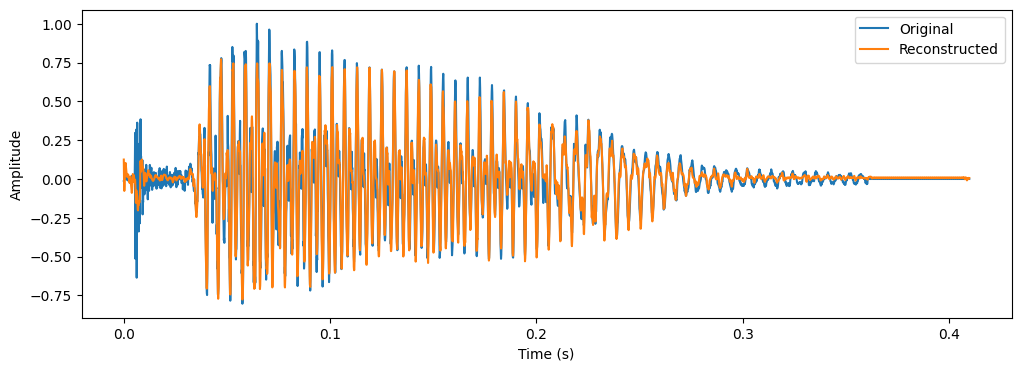

Reconstructed Audio:


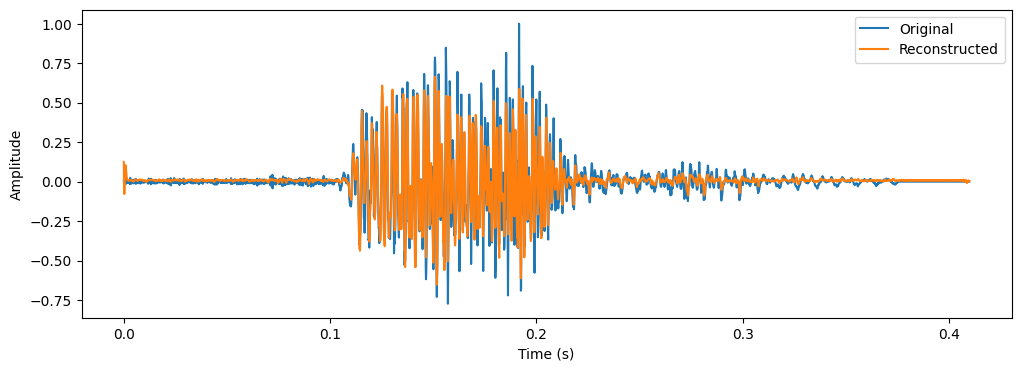

Reconstructed Audio:


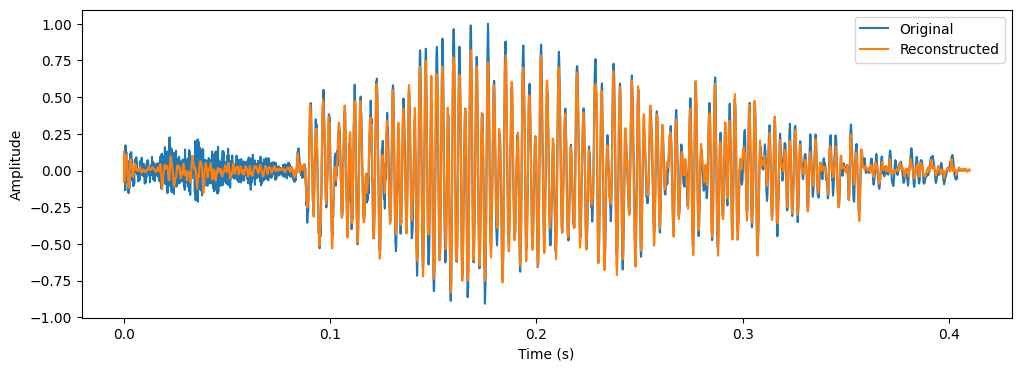

Reconstructed Audio:


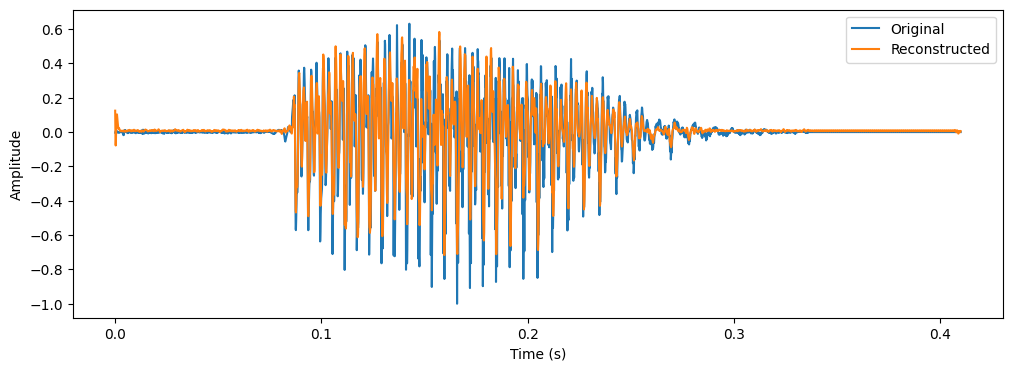

Reconstructed Audio:


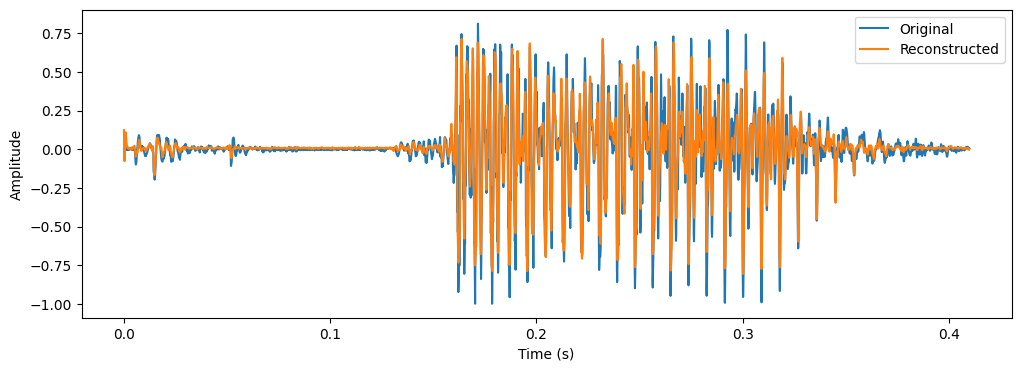

In [35]:
for i in range(5):
    audio_data = test_audio[i]
    rec_audio = reconstructed_audio[0][i]
    display(Audio(data=audio_data.numpy().flatten(), rate=SAMPLE_RATE))
        
    print("Reconstructed Audio:")
    display(Audio(data=rec_audio.flatten(), rate=SAMPLE_RATE))

    # Plotting the waveform
    plt.figure(figsize=(12, 4))
    time_axis = np.arange(len(audio_data.numpy().flatten())) / SAMPLE_RATE
    plt.plot(time_axis, audio_data.numpy().flatten(), label='Original')
    plt.plot(time_axis, rec_audio.flatten(), label='Reconstructed')
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

b) The VQ-VAE quantisation layer emits a sequence of discrete codes for a given audio input. During training, the prior distribution over these codes is kept uniform. In order to use the model to generate audio, it is necessary to train a second model to predict likely sequences of codebook vectors. 

This second model is usually referred to in the literature as a 'prior' model (note that this is not really a prior, as it is trained on the data). We will adopt this same terminology here.

You should design, implement and train a prior model to generate sequences of codebook vectors, using the output of the trained VQ-VAE encoder and quantisation stage, using the same training data that was used to train the VQ-VAE. You are again free to choose any architecture for the prior model.

Your trained model should generate a sequence that can be decoded by the VQ-VAE to output audio.

You should record any experiments you carry out along with the training logs, to be reported in question 4. Your code in this question does not need to be presented so that it runs all experiments, it can be set out to run the best set of hyperparameters, according to your validation results. You should aim to try at least two sets of hyperparameters.

Display some examples (playable using the Audio class from the IPython.display module as in question 1) generated using your prior and VQ-VAE model.

**(15 marks)**

In [36]:
import tensorflow_probability as tfp
tfd = tfp.distributions

In [37]:
# Prepare the training data for the prior model
def prepare_prior_data(model, dataset):
    codes_list = []
    for batch in dataset:
        _, z_e, _ = model(batch["audio"], training=False)
        codes = tf.argmin(tf.norm(tf.expand_dims(z_e, axis=2) - model.rvq_layer.embeddings[0], axis=-1), axis=-1)
        codes_list.append(codes)
    return tf.concat(codes_list, axis=0)

In [38]:
# Prepare the training data for the prior model
codes = prepare_prior_data(vqvae_model, train_ds)

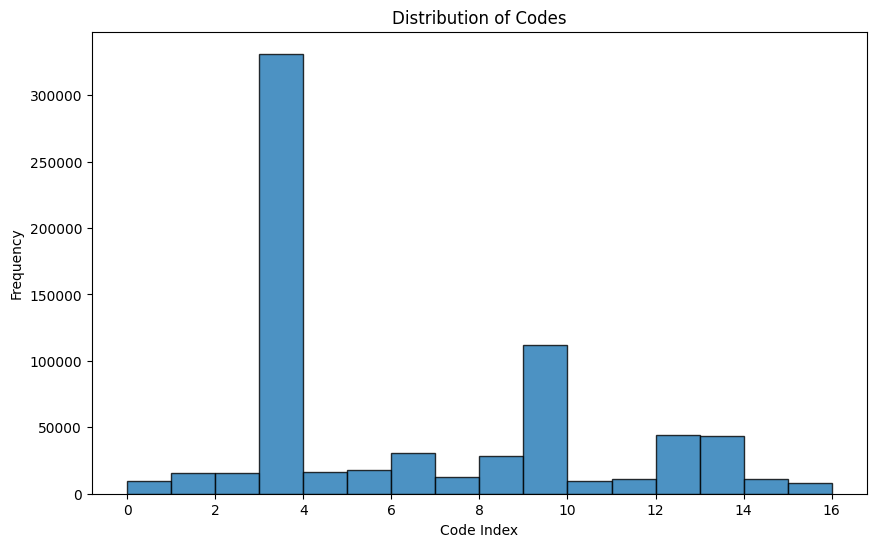

In [39]:
plt.figure(figsize=(10, 6))
plt.hist(codes.numpy().flatten(), bins=num_embeddings, range=(0, num_embeddings), alpha=0.8, edgecolor='black')
plt.xlabel('Code Index')
plt.ylabel('Frequency')
plt.title('Distribution of Codes')
plt.show()

### Question 4 (Total 15 marks)

Provide a separate PDF report with an account of the models and experiment design you have made in question 3. Your report should include details of the choices you have made throughout the development of the models, including the data processing, architecture design, hyperparameter settings/experiments and training algorithm. Where appropriate, you can also provide your intuition behind these choices. 

Your report should also include the results from your experiments, highlighting the best choice of hyperparameters that you found. If you encountered difficulties to successfully train the model(s) you should report these, and if possible suggest what you think might be potential reasons for these difficulties. Are there additional experiments or modifications to the model and/or training algorithm that you would have liked to make given more time?

Marks will be awarded for presentation and clarity. Your report should be no more than 2-3 pages.

**(15 marks)**